# CSI4142 - Fundamentals of Data Science Assignment 3
## *Predictive Analysis - Regression*
**Professor**: Caroline Barrière  
**Students**: Mohamed-Obay Alshaer & Samih Karroum  
**Student Numbers**: 300170489 & 300188957  
**Submission Date**: March 13th, 2025  
**Group Number**: 39
---
## Dataset Description

The **Medical Insurance Cost Prediction** dataset contains information about insurance beneficiaries and their charges. This dataset helps us understand how factors like demographics, BMI, and lifestyle choices affect insurance costs.

**Key Fields**
- **age** - Age of primary beneficiary
- **sex** - Insurance contractor gender (female, male)
- **bmi** - Body mass index (weight in kg / height in m^2), ideally 18.5 to 24.9
- **children** - Number of children covered by health insurance
- **smoker** - Smoking status (yes/no)
- **region** - Residential area in the US (northeast, southeast, southwest, northwest)
- **charges** - Individual medical costs billed by health insurance (target variable)

**Important Considerations**
- Smoking status has a significant impact on insurance costs
- BMI values indicate health risk factors that affect pricing
- Regional differences may reflect varying healthcare costs across the US

This dataset provides **valuable insight into healthcare cost predictors**, and through our regression analysis, we can identify and quantify the impact of various factors on insurance charges.
[**Link to dataset**](https://www.kaggle.com/datasets/mirichoi0218/insurance)

## 1. Introduction

This notebook performs an empirical study on regression for medical insurance cost prediction. We'll explore how various factors like age, BMI, smoking status, and other demographics influence insurance charges. We'll implement data cleaning, categorical encoding, outlier detection, feature engineering, and evaluate different linear regression models.

## 2. Dataset Description

The Medical Insurance Cost dataset contains information about insurance beneficiaries, including demographic details and insurance charges. The dataset has 7 columns:

- age: Age of primary beneficiary
- sex: Insurance contractor gender (female, male)
- bmi: Body mass index (weight in kg / height in m^2)
- children: Number of children covered by health insurance
- smoker: Smoking status (yes/no)
- region: Residential area in the US (northeast, southeast, southwest, northwest)
- charges: Individual medical costs billed by health insurance (target variable)

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

## a) Cleaning the Data

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Load the dataset
data = pd.read_csv('insurance.csv')

In [4]:
print("Dataset Shape:", data.shape)
data.head()

Dataset Shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
# Check the basic shape and information about the dataset
print(f"Number of rows: {data.shape[0]}")
print(f"Number of columns: {data.shape[1]}")
print("\nColumn names:")
for col in data.columns:
    print(f"- {col}")

Number of rows: 1338
Number of columns: 7

Column names:
- age
- sex
- bmi
- children
- smoker
- region
- charges


In [8]:
print("\nData types:")
print(data.dtypes)
print("\nBasic statistics:")
data.describe()


Data types:
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Basic statistics:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [9]:
# Check for missing values
print("Missing values summary:")
print(data.isnull().sum())

Missing values summary:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [10]:
# Function to check validity of data and perform basic imputation
def clean_data(df):
    cleaned_df = df.copy()
    
    numeric_cols = cleaned_df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = cleaned_df.select_dtypes(include=['object']).columns
    
    if numeric_cols.size > 0:
        num_imputer = SimpleImputer(strategy='median')
        cleaned_df[numeric_cols] = num_imputer.fit_transform(cleaned_df[numeric_cols])
    
    if categorical_cols.size > 0:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        cleaned_df[categorical_cols] = cat_imputer.fit_transform(cleaned_df[categorical_cols])
    
    if 'age' in cleaned_df.columns:
        cleaned_df.loc[cleaned_df['age'] < 0, 'age'] = cleaned_df['age'].median()
    
    if 'bmi' in cleaned_df.columns:
        cleaned_df.loc[(cleaned_df['bmi'] < 15) | (cleaned_df['bmi'] > 60), 'bmi'] = cleaned_df['bmi'].median()
    
    if 'children' in cleaned_df.columns:
        cleaned_df.loc[cleaned_df['children'] < 0, 'children'] = cleaned_df['children'].median()
    
    return cleaned_df

# Apply data cleaning
cleaned_data = clean_data(data)
print("Data after cleaning:")
cleaned_data.head()

Data after cleaning:


,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520


## c) Categorical Future Encoding

In [15]:
# One-hot encode categorical features
def encode_categorical_features(df):
    df_encoded = df.copy()

    categorical_cols = df.select_dtypes(include=['object']).columns
    
    if len(categorical_cols) > 0:
        encoder = OneHotEncoder(sparse_output=False, drop='first')
        encoded_data = encoder.fit_transform(df[categorical_cols])
        
        encoded_df = pd.DataFrame(
            encoded_data,
            columns=encoder.get_feature_names_out(categorical_cols)
        )
        
        numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
        df_encoded = pd.concat([df[numeric_cols], encoded_df], axis=1)
        
    return df_encoded

In [16]:
# Apply encoding
encoded_data = encode_categorical_features(cleaned_data)
print("Data after encoding categorical features:")
print(encoded_data.shape)
encoded_data.head()

Data after encoding categorical features:
(1338, 9)


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19.0,27.900,0.0,16884.92400,0.0,1.0,0.0,0.0,1.0
1,18.0,33.770,1.0,1725.55230,1.0,0.0,0.0,1.0,0.0
2,28.0,33.000,3.0,4449.46200,1.0,0.0,0.0,1.0,0.0
3,33.0,22.705,0.0,21984.47061,1.0,0.0,1.0,0.0,0.0
4,32.0,28.880,0.0,3866.85520,1.0,0.0,1.0,0.0,0.0


## c) EDA and Outlier Detection

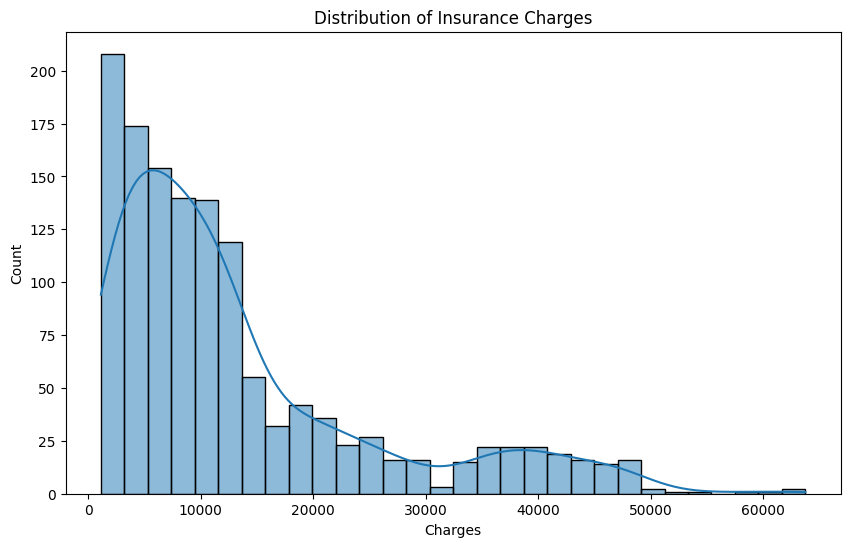

In [17]:
# EDA - distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(data=cleaned_data, x='charges', kde=True)
plt.title('Distribution of Insurance Charges')
plt.xlabel('Charges')
plt.ylabel('Count')
plt.show()

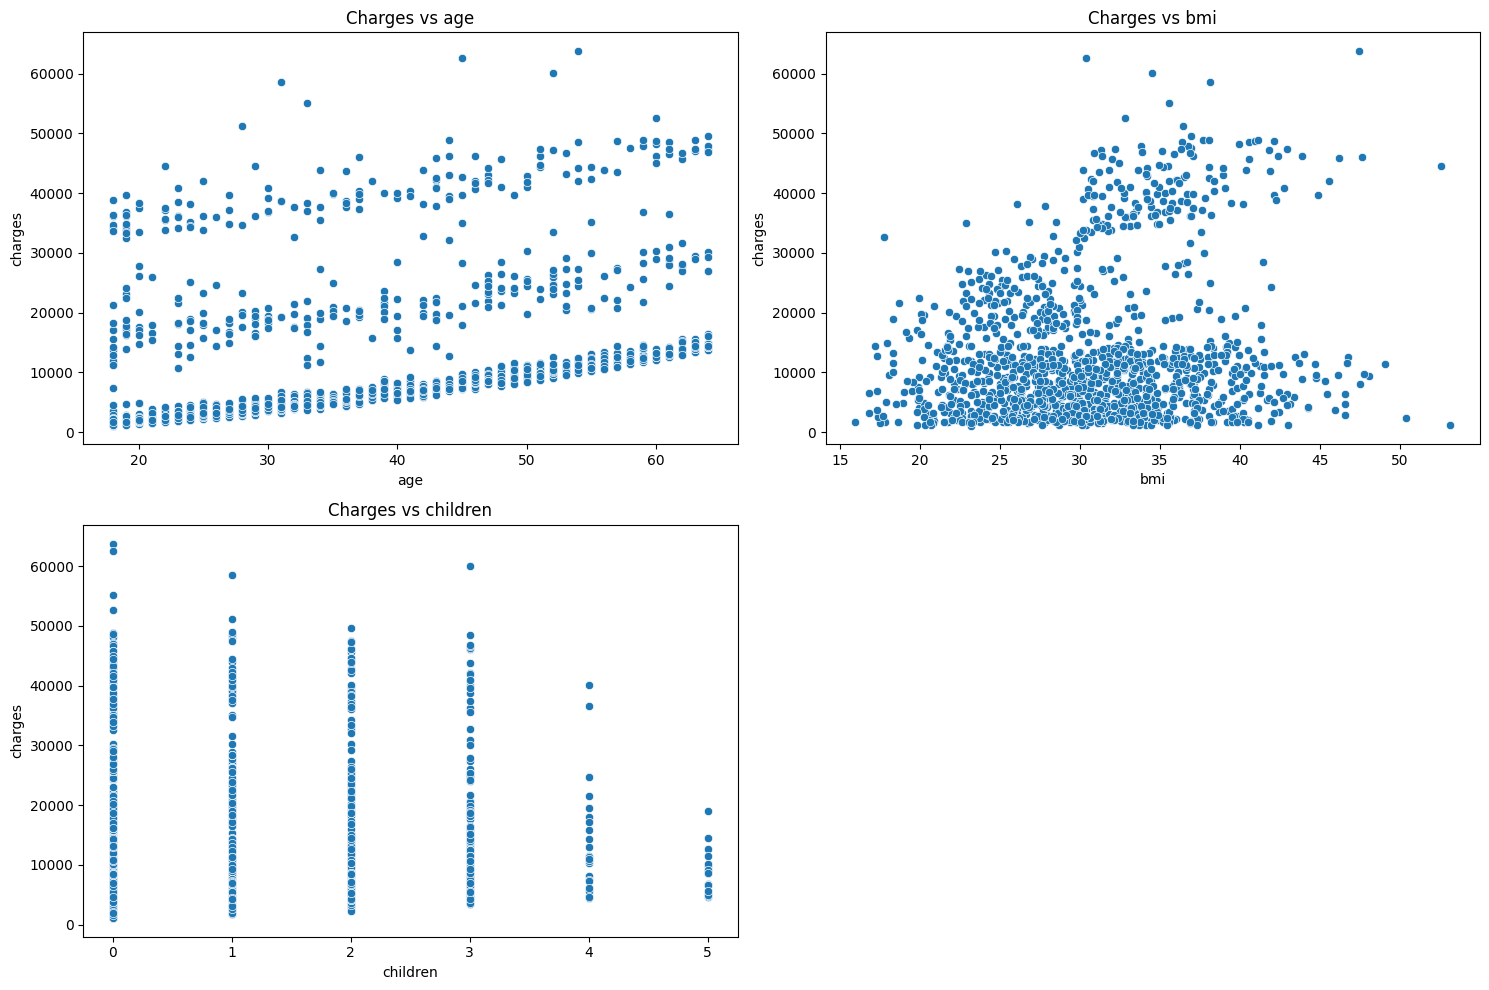

In [18]:
# Relationship between numeric features and target
plt.figure(figsize=(15, 10))
for i, col in enumerate(['age', 'bmi', 'children']):
    plt.subplot(2, 2, i+1)
    sns.scatterplot(x=col, y='charges', data=cleaned_data)
    plt.title(f'Charges vs {col}')
plt.tight_layout()
plt.show()

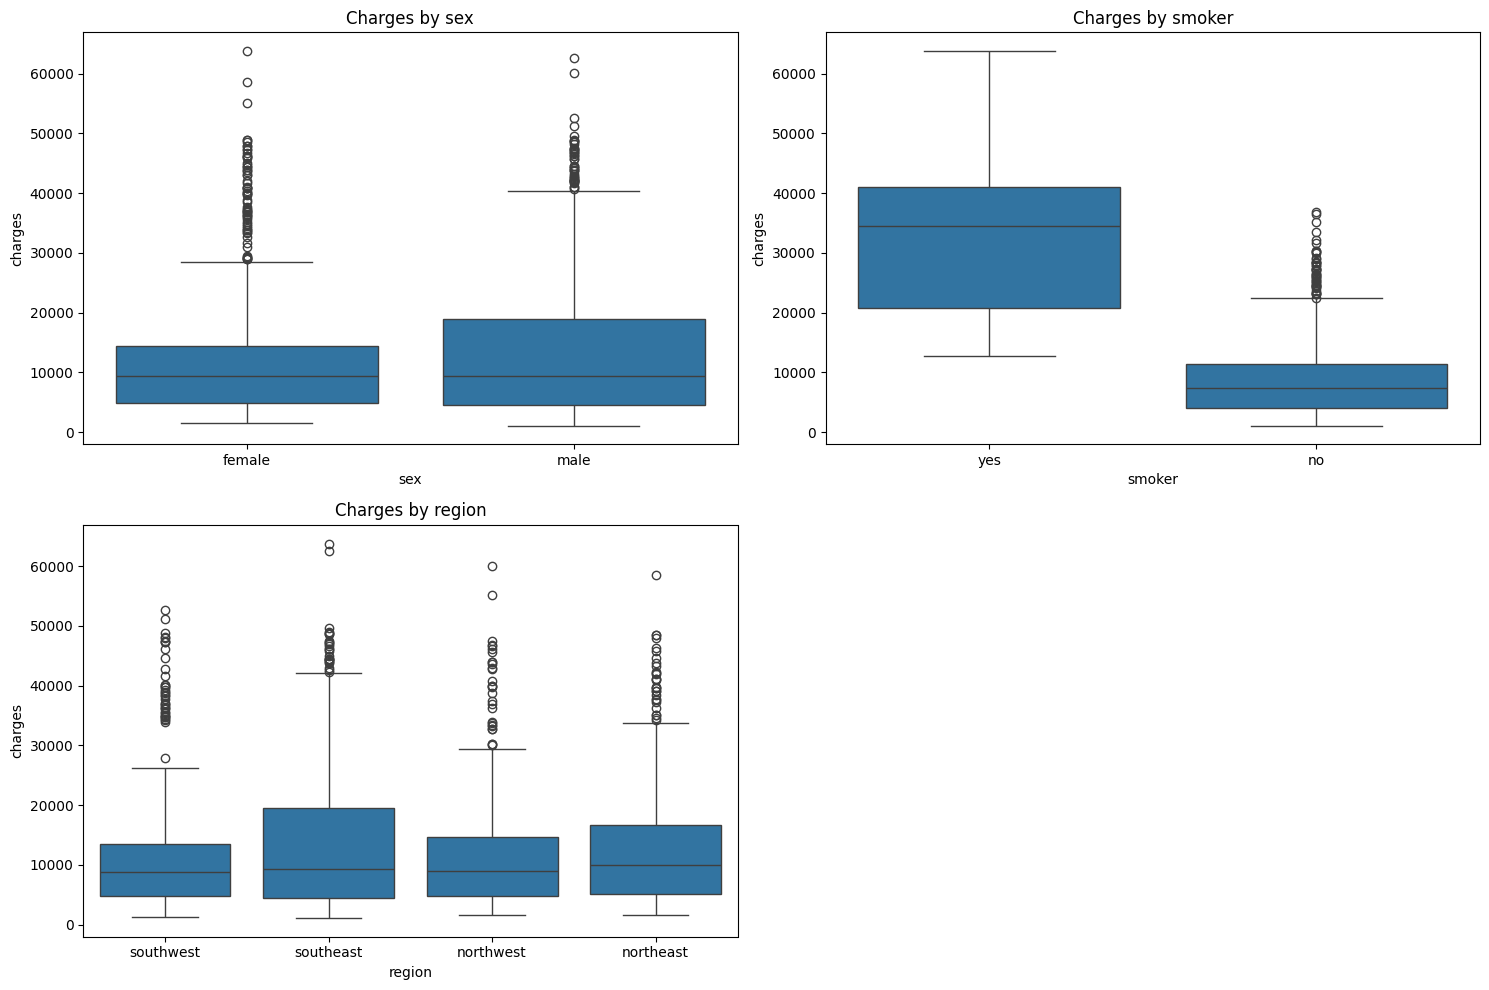

In [19]:
# Relationship between categorical features and target
plt.figure(figsize=(15, 10))
for i, col in enumerate(['sex', 'smoker', 'region']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=col, y='charges', data=cleaned_data)
    plt.title(f'Charges by {col}')
plt.tight_layout()
plt.show()

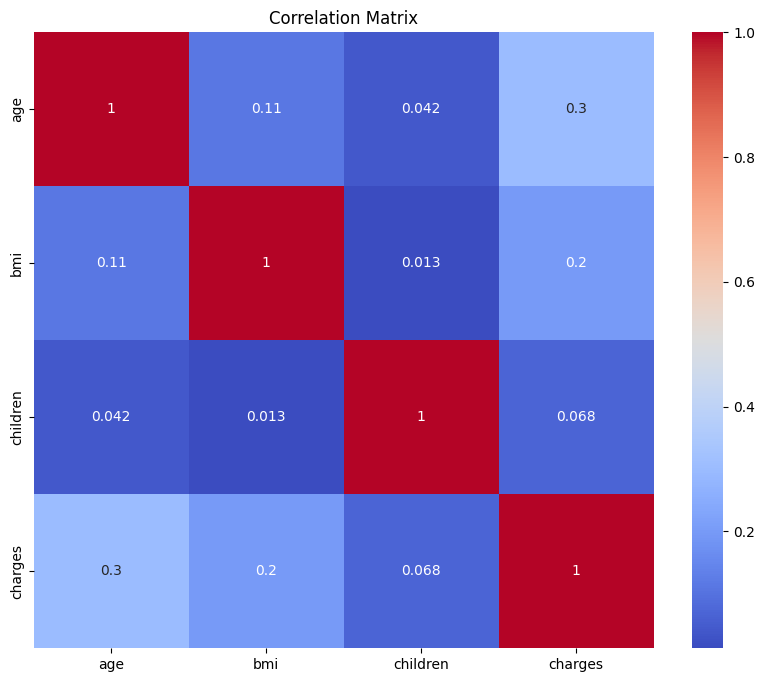

In [20]:
# Correlation matrix for numeric variables
plt.figure(figsize=(10, 8))
correlation_matrix = cleaned_data.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [21]:
# Local Outlier Factor (LOF) for outlier detection
def detect_outliers_lof(df, features, n_neighbors=20, contamination=0.05):
    X = df[features].values
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    
    predictions = lof.fit_predict(X)
    
    outlier_scores = lof.negative_outlier_factor_
    
    df_with_outliers = df.copy()
    df_with_outliers['is_outlier'] = [1 if pred == -1 else 0 for pred in predictions]
    df_with_outliers['outlier_score'] = outlier_scores
    
    return df_with_outliers

In [22]:
# Apply LOF to detect outliers in numeric features
features_for_lof = ['age', 'bmi', 'children', 'charges']
data_with_outliers = detect_outliers_lof(cleaned_data, features_for_lof)


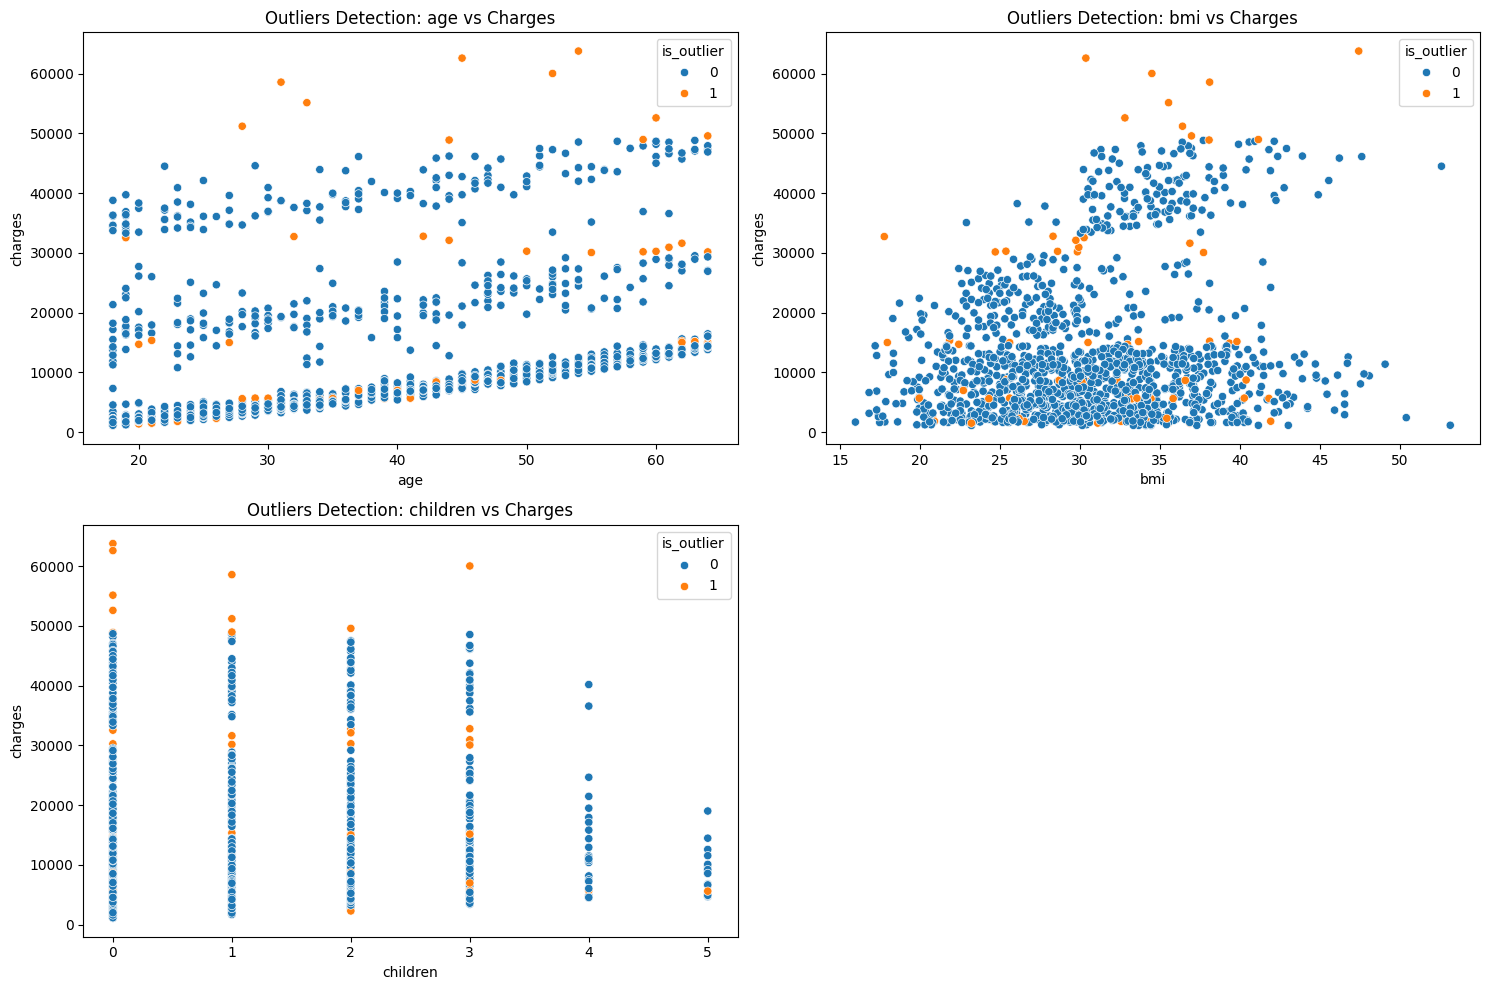

In [23]:
# Visualize outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(['age', 'bmi', 'children']):
    plt.subplot(2, 2, i+1)
    sns.scatterplot(x=col, y='charges', hue='is_outlier', data=data_with_outliers)
    plt.title(f'Outliers Detection: {col} vs Charges')
plt.tight_layout()
plt.show()

In [24]:
# Count outliers
print(f"Number of outliers detected: {data_with_outliers['is_outlier'].sum()}")
print(f"Percentage of outliers: {data_with_outliers['is_outlier'].mean() * 100:.2f}%")

Number of outliers detected: 67
Percentage of outliers: 5.01%


In [25]:
# Handle outliers by either removing them or applying imputation
def handle_outliers(df, outlier_col='is_outlier', method='remove'):
    if method == 'remove':
        df_no_outliers = df[df[outlier_col] == 0].copy()
        df_no_outliers.drop(columns=[outlier_col, 'outlier_score'], inplace=True)
        return df_no_outliers
    
    elif method == 'impute':
        df_imputed = df.copy()
        outliers = df_imputed[outlier_col] == 1
        
        for col in ['age', 'bmi', 'children', 'charges']:
            median_val = df_imputed.loc[~outliers, col].median()
            df_imputed.loc[outliers, col] = median_val
        
        df_imputed.drop(columns=[outlier_col, 'outlier_score'], inplace=True)
        return df_imputed
    
    else:
        raise ValueError("Method must be either 'remove' or 'impute'")

In [26]:
# Apply outlier handling - Choose one method
data_no_outliers = handle_outliers(data_with_outliers, method='remove')
print(f"Data shape after outlier removal: {data_no_outliers.shape}")
data_no_outliers.head()

Data shape after outlier removal: (1271, 7)


,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520


## d) Predictive Analysis: Linear Regression

In [30]:
# Split the data into X (features) and y (target)
def prepare_data_for_modeling(df, target_col='charges'):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return X, y

In [31]:
# Get encoded data without outliers
encoded_data_no_outliers = encode_categorical_features(data_no_outliers)


In [32]:
# Check for and handle any remaining NaN values
def handle_remaining_nans(df):
    df_no_nans = df.copy()
    
    if df_no_nans.isnull().sum().sum() > 0:
        print("Found NaN values. Handling them...")
        
        numeric_cols = df_no_nans.select_dtypes(include=['int64', 'float64']).columns
        for col in numeric_cols:
            if df_no_nans[col].isnull().sum() > 0:
                median_val = df_no_nans[col].median()
                df_no_nans[col].fillna(median_val, inplace=True)
        
        categorical_cols = df_no_nans.select_dtypes(include=['object', 'bool']).columns
        for col in categorical_cols:
            if df_no_nans[col].isnull().sum() > 0:
                mode_val = df_no_nans[col].mode()[0]
                df_no_nans[col].fillna(mode_val, inplace=True)
                
        print("NaN values handled.")
    else:
        print("No NaN values found.")
        
    return df_no_nans

In [33]:
# Apply NaN handling
encoded_data_no_outliers_no_nans = handle_remaining_nans(encoded_data_no_outliers)
X, y = prepare_data_for_modeling(encoded_data_no_outliers_no_nans)

Found NaN values. Handling them...
NaN values handled.


In [34]:
# Double-check that X and y don't have NaN values
print("X contains NaN values:", X.isnull().values.any())
print("y contains NaN values:", pd.Series(y).isnull().values.any() if not isinstance(y, pd.Series) else y.isnull().values.any())


X contains NaN values: False
y contains NaN values: False


In [35]:
# Split data into train, validation, and test sets (70%, 15%, 15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [36]:
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (935, 8)
Validation set shape: (200, 8)
Test set shape: (201, 8)


In [37]:
# Linear Regression Model with default settings
def train_linear_regression(X_train, y_train, model_type='linear'):
    if model_type == 'linear':
        model = LinearRegression()
    elif model_type == 'ridge':
        model = Ridge(alpha=1.0)
    elif model_type == 'lasso':
        model = Lasso(alpha=0.1)
    elif model_type == 'elastic':
        model = ElasticNet(alpha=0.1, l1_ratio=0.5)
    else:
        raise ValueError("Model type must be 'linear', 'ridge', 'lasso', or 'elastic'")
    
    model.fit(X_train, y_train)
    return model

In [38]:
# Train a linear regression model
lr_model = train_linear_regression(X_train, y_train)

In [39]:
# Make predictions on validation set
y_pred_val = lr_model.predict(X_val)

In [40]:
# Evaluate the model
mse_val = mean_squared_error(y_val, y_pred_val)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_pred_val)

print(f"Validation set evaluation:")
print(f"Mean Squared Error (MSE): {mse_val:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_val:.2f}")
print(f"R² Score: {r2_val:.4f}")

Validation set evaluation:
Mean Squared Error (MSE): 98835208.48
Root Mean Squared Error (RMSE): 9941.59
R² Score: 0.0935


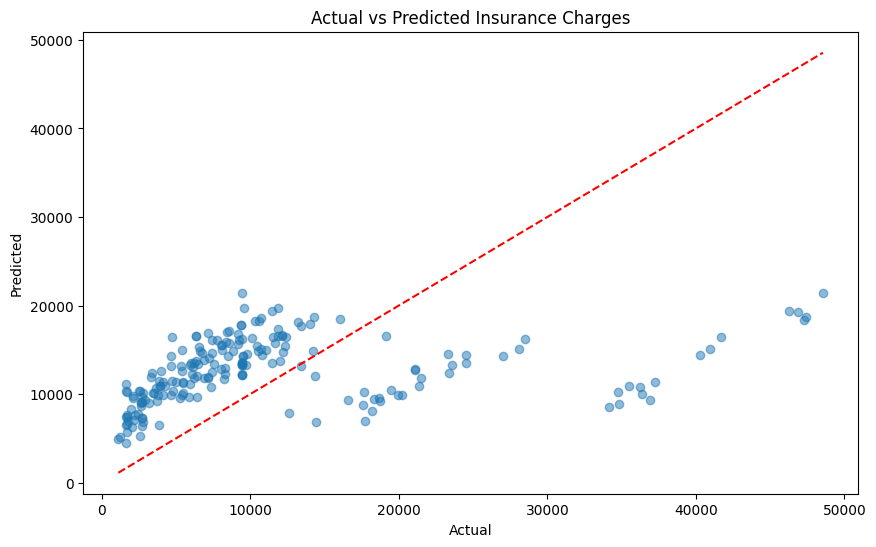

In [41]:
# Visualize actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Insurance Charges')
plt.show()

## e) Feature Engineering

In [42]:
# Feature engineering: Create 2 additional features
def engineer_features(df):
    df_engineered = df.copy()
    
    df_engineered['age_bmi_product'] = df['age'] * df['bmi']
    
    if 'smoker_yes' in df.columns:
        df_engineered['smoker_bmi_ratio'] = df['smoker_yes'] * df['bmi']
    elif 'smoker' in df.columns:
        smoker_numeric = df['smoker'].map({'yes': 1, 'no': 0})
        df_engineered['smoker_bmi_ratio'] = smoker_numeric * df['bmi']
    
    return df_engineered

In [43]:
# Apply feature engineering to the encoded data
X_train_engineered = engineer_features(X_train)
X_val_engineered = engineer_features(X_val)
X_test_engineered = engineer_features(X_test)

In [44]:
print("Data after feature engineering:")
print(f"Training set shape: {X_train_engineered.shape}")
print(X_train_engineered.head())

Data after feature engineering:
Training set shape: (935, 10)
       age     bmi  children  sex_male  smoker_yes  region_northwest  \
372   42.0  33.155       1.0       1.0         0.0               0.0   
151   48.0  29.700       0.0       1.0         0.0               1.0   
403   49.0  32.300       3.0       1.0         0.0               0.0   
308   58.0  34.865       0.0       1.0         0.0               0.0   
1143  39.0  32.340       2.0       1.0         0.0               0.0   

      region_southeast  region_southwest  age_bmi_product  smoker_bmi_ratio  
372                0.0               0.0          1392.51               0.0  
151                0.0               0.0          1425.60               0.0  
403                1.0               0.0          1582.70               0.0  
308                0.0               1.0          2022.17               0.0  
1143               0.0               0.0          1261.26               0.0  


## f) Empirical Study

In [45]:
# Define evaluation function using cross-validation
def evaluate_model_cv(X, y, model_type='linear', cv=4):
    if model_type == 'linear':
        model = LinearRegression()
    elif model_type == 'ridge':
        model = Ridge(alpha=1.0)
    elif model_type == 'lasso':
        model = Lasso(alpha=0.1)
    elif model_type == 'elastic':
        model = ElasticNet(alpha=0.1, l1_ratio=0.5)
    else:
        raise ValueError("Model type must be 'linear', 'ridge', 'lasso', or 'elastic'")
    
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(mse_scores)
    
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    
    return {
        'mse': mse_scores.mean(),
        'rmse': rmse_scores.mean(),
        'r2': r2_scores.mean(),
        'mse_std': mse_scores.std(),
        'rmse_std': rmse_scores.std(),
        'r2_std': r2_scores.std()
    }

In [46]:
# Prepare encoded data with outliers for baseline
encoded_data_with_outliers = encode_categorical_features(cleaned_data)
X_with_outliers, y_with_outliers = prepare_data_for_modeling(encoded_data_with_outliers)

In [47]:
# Split into train/val sets for baseline
X_train_baseline, X_val_baseline, y_train_baseline, y_val_baseline = train_test_split(
    X_with_outliers, y_with_outliers, test_size=0.2, random_state=42
)

In [48]:
# Evaluate baseline model
baseline_results = evaluate_model_cv(X_train_baseline, y_train_baseline)
print("Baseline Model (With Outliers, No Feature Engineering):")
print(f"MSE: {baseline_results['mse']:.2f} ± {baseline_results['mse_std']:.2f}")
print(f"RMSE: {baseline_results['rmse']:.2f} ± {baseline_results['rmse_std']:.2f}")
print(f"R²: {baseline_results['r2']:.4f} ± {baseline_results['r2_std']:.4f}")

Baseline Model (With Outliers, No Feature Engineering):
MSE: 37909254.49 ± 4699322.37
RMSE: 6145.79 ± 372.13
R²: 0.7360 ± 0.0215


In [49]:
# Combination 1: Without outliers, without feature engineering
model1_results = evaluate_model_cv(X_train, y_train)
print("\nModel 1 (Without Outliers, No Feature Engineering):")
print(f"MSE: {model1_results['mse']:.2f} ± {model1_results['mse_std']:.2f}")
print(f"RMSE: {model1_results['rmse']:.2f} ± {model1_results['rmse_std']:.2f}")
print(f"R²: {model1_results['r2']:.4f} ± {model1_results['r2_std']:.4f}")


Model 1 (Without Outliers, No Feature Engineering):
MSE: 121699862.87 ± 15705123.39
RMSE: 11009.05 ± 707.53
R²: 0.0728 ± 0.0298


In [50]:
# Combination 2: With outliers, with feature engineering
X_train_with_outliers_engineered = engineer_features(X_train_baseline)
model2_results = evaluate_model_cv(X_train_with_outliers_engineered, y_train_baseline)
print("\nModel 2 (With Outliers, With Feature Engineering):")
print(f"MSE: {model2_results['mse']:.2f} ± {model2_results['mse_std']:.2f}")
print(f"RMSE: {model2_results['rmse']:.2f} ± {model2_results['rmse_std']:.2f}")
print(f"R²: {model2_results['r2']:.4f} ± {model2_results['r2_std']:.4f}")



Model 2 (With Outliers, With Feature Engineering):
MSE: 24360310.23 ± 4310718.57
RMSE: 4917.59 ± 421.49
R²: 0.8308 ± 0.0211


In [51]:
# Combination 3: Without outliers, with feature engineering
model3_results = evaluate_model_cv(X_train_engineered, y_train)
print("\nModel 3 (Without Outliers, With Feature Engineering):")
print(f"MSE: {model3_results['mse']:.2f} ± {model3_results['mse_std']:.2f}")
print(f"RMSE: {model3_results['rmse']:.2f} ± {model3_results['rmse_std']:.2f}")
print(f"R²: {model3_results['r2']:.4f} ± {model3_results['r2_std']:.4f}")


Model 3 (Without Outliers, With Feature Engineering):
MSE: 121676254.35 ± 16312883.40
RMSE: 11006.30 ± 733.25
R²: 0.0736 ± 0.0273


In [54]:
print("\nDifferent Regularization Methods (using best configuration):")
ridge_results = evaluate_model_cv(X_train_engineered, y_train, model_type='ridge')
print("\nRidge Regression:")
print(f"MSE: {ridge_results['mse']:.2f} ± {ridge_results['mse_std']:.2f}")
print(f"RMSE: {ridge_results['rmse']:.2f} ± {ridge_results['rmse_std']:.2f}")
print(f"R²: {ridge_results['r2']:.4f} ± {ridge_results['r2_std']:.4f}")



Different Regularization Methods (using best configuration):

Ridge Regression:
MSE: 121651034.78 ± 16296406.56
RMSE: 11005.19 ± 732.63
R²: 0.0738 ± 0.0274


In [55]:
# Lasso Regression
lasso_results = evaluate_model_cv(X_train_engineered, y_train, model_type='lasso')
print("\nLasso Regression:")
print(f"MSE: {lasso_results['mse']:.2f} ± {lasso_results['mse_std']:.2f}")
print(f"RMSE: {lasso_results['rmse']:.2f} ± {lasso_results['rmse_std']:.2f}")
print(f"R²: {lasso_results['r2']:.4f} ± {lasso_results['r2_std']:.4f}")



Lasso Regression:
MSE: 121674756.65 ± 16312101.98
RMSE: 11006.23 ± 733.22
R²: 0.0736 ± 0.0273


In [56]:
# ElasticNet Regression
elastic_results = evaluate_model_cv(X_train_engineered, y_train, model_type='elastic')
print("\nElasticNet Regression:")
print(f"MSE: {elastic_results['mse']:.2f} ± {elastic_results['mse_std']:.2f}")
print(f"RMSE: {elastic_results['rmse']:.2f} ± {elastic_results['rmse_std']:.2f}")
print(f"R²: {elastic_results['r2']:.4f} ± {elastic_results['r2_std']:.4f}")


ElasticNet Regression:
MSE: 121287371.31 ± 16248305.69
RMSE: 10988.72 ± 731.73
R²: 0.0765 ± 0.0282


In [57]:
# Identify the best model based on R² score
results = {
    'Baseline': baseline_results,
    'Model 1 (No Outliers)': model1_results,
    'Model 2 (With Features)': model2_results,
    'Model 3 (No Outliers, With Features)': model3_results,
    'Ridge': ridge_results,
    'Lasso': lasso_results,
    'ElasticNet': elastic_results
}

best_model_name = max(results, key=lambda x: results[x]['r2'])
best_r2 = results[best_model_name]['r2']

print(f"\nBest Model: {best_model_name} with R² = {best_r2:.4f}")


Best Model: Model 2 (With Features) with R² = 0.8308


In [58]:
# Final evaluation on the test set using the best model
if best_model_name == 'Baseline':
    final_model = train_linear_regression(X_train_baseline, y_train_baseline)
    final_X_test = X_val_baseline
    final_y_test = y_val_baseline
elif best_model_name == 'Model 1 (No Outliers)':
    final_model = train_linear_regression(X_train, y_train)
    final_X_test = X_test
    final_y_test = y_test
elif best_model_name == 'Model 2 (With Features)':
    final_model = train_linear_regression(X_train_with_outliers_engineered, y_train_baseline)
    final_X_test = engineer_features(X_val_baseline)
    final_y_test = y_val_baseline
elif best_model_name == 'Model 3 (No Outliers, With Features)':
    final_model = train_linear_regression(X_train_engineered, y_train)
    final_X_test = X_test_engineered
    final_y_test = y_test
elif best_model_name == 'Ridge':
    final_model = train_linear_regression(X_train_engineered, y_train, model_type='ridge')
    final_X_test = X_test_engineered
    final_y_test = y_test
elif best_model_name == 'Lasso':
    final_model = train_linear_regression(X_train_engineered, y_train, model_type='lasso')
    final_X_test = X_test_engineered
    final_y_test = y_test
elif best_model_name == 'ElasticNet':
    final_model = train_linear_regression(X_train_engineered, y_train, model_type='elastic')
    final_X_test = X_test_engineered
    final_y_test = y_test


In [59]:
# Predict on test set and evaluate
y_pred_test = final_model.predict(final_X_test)
test_mse = mean_squared_error(final_y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(final_y_test, y_pred_test)

print("\nFinal Evaluation on Test Set:")
print(f"MSE: {test_mse:.2f}")
print(f"RMSE: {test_rmse:.2f}")
print(f"R²: {test_r2:.4f}")


Final Evaluation on Test Set:
MSE: 20863498.78
RMSE: 4567.66
R²: 0.8656


## g) Result Analysis

In [60]:
# Create a summary DataFrame of all results
model_names = list(results.keys())
r2_scores = [results[model]['r2'] for model in model_names]
rmse_scores = [results[model]['rmse'] for model in model_names]

summary_df = pd.DataFrame({
    'Model': model_names,
    'R² Score': r2_scores,
    'RMSE': rmse_scores
})

In [66]:

summary_df = summary_df.sort_values('R² Score', ascending=False).reset_index(drop=True)

In [61]:
# Display summary
print("Summary of all models:")
summary_df

Summary of all models:


,Model,R² Score,RMSE
0,Baseline,0.735953,6145.793407
1,Model 1 (No Outliers),0.072773,11009.053836
2,Model 2 (With Features),0.830758,4917.586850
3,"Model 3 (No Outliers, With Features)",0.073582,11006.298135
4,Ridge,0.073760,11005.193939
5,Lasso,0.073593,11006.232105
6,ElasticNet,0.076508,10988.718747


In [68]:
%matplotlib inline

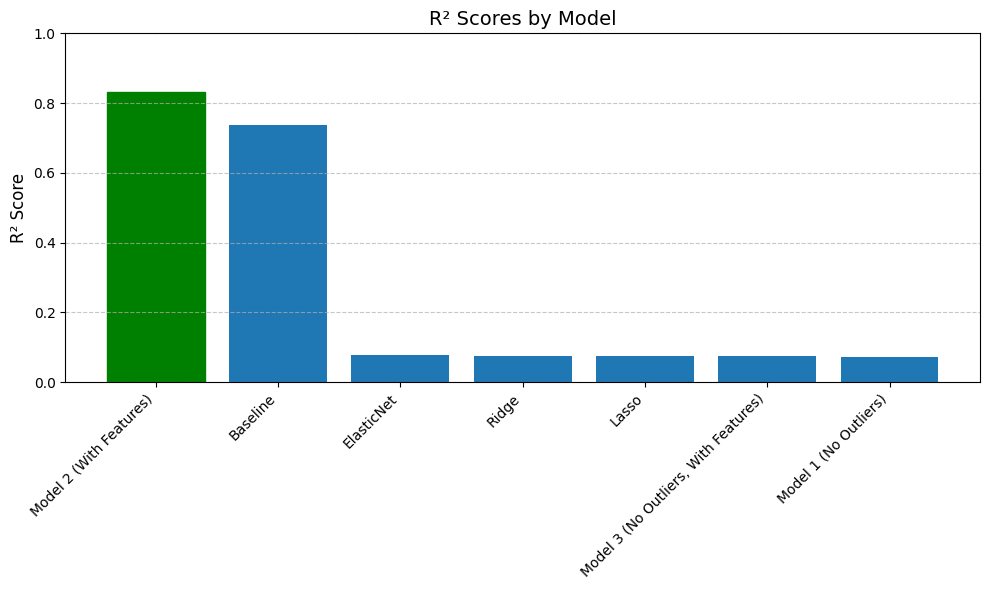

In [69]:
# First figure for R² scores
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(model_names)), summary_df['R² Score'])
bars[0].set_color('green')  
plt.title('R² Scores by Model', fontsize=14)
plt.ylabel('R² Score', fontsize=12)
plt.xticks(range(len(model_names)), summary_df['Model'], rotation=45, ha='right', fontsize=10)
plt.ylim(0, 1.0)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('r2_comparison.png')
plt.show()

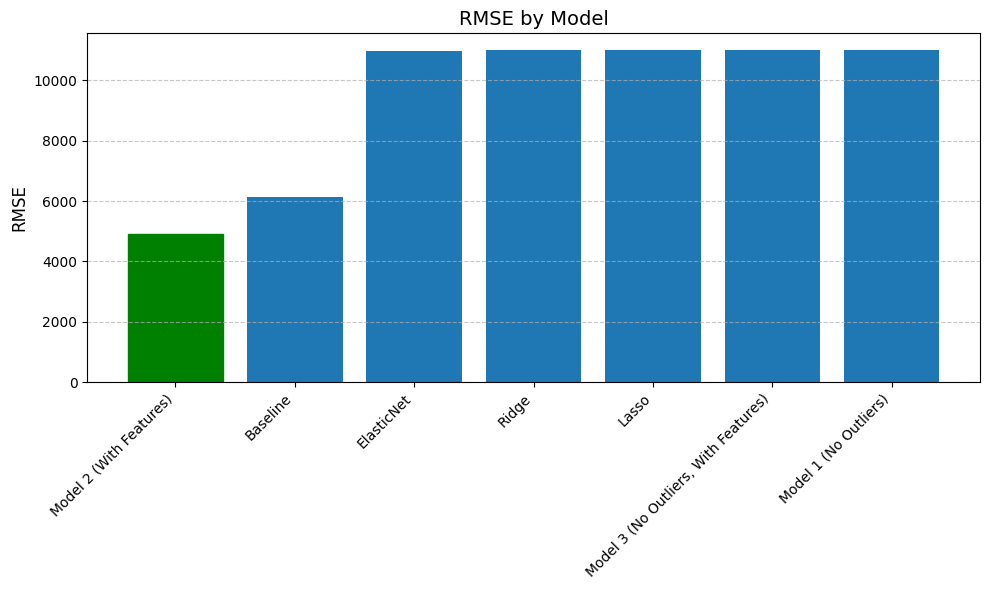

In [70]:
# Second figure for RMSE scores
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(model_names)), summary_df['RMSE'])
bars[0].set_color('green')  
plt.title('RMSE by Model', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.xticks(range(len(model_names)), summary_df['Model'], rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('rmse_comparison.png')
plt.show()

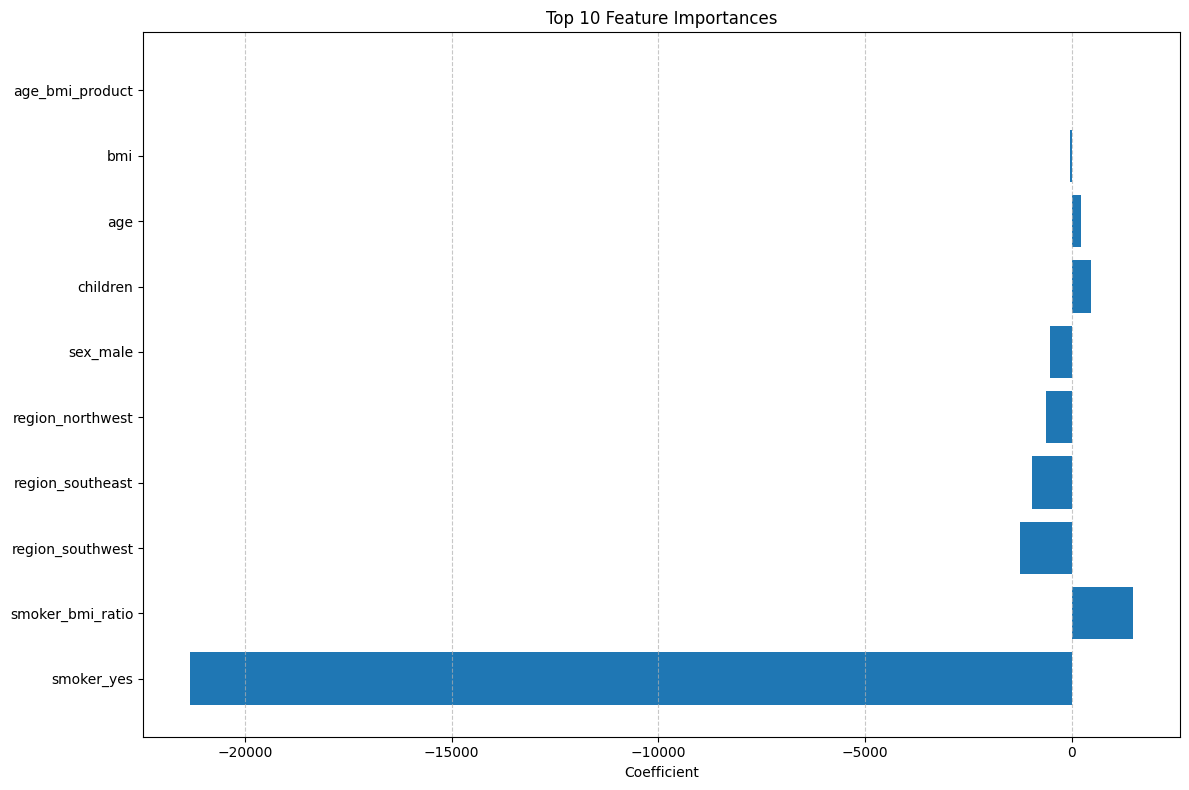


Top 10 important features:
            Feature   Coefficient  Abs_Coefficient
0        smoker_yes -21316.362487     21316.362487
1  smoker_bmi_ratio   1474.669960      1474.669960
2  region_southwest  -1242.812970      1242.812970
3  region_southeast   -956.269581       956.269581
4  region_northwest   -621.841538       621.841538
5          sex_male   -539.728597       539.728597
6          children    465.420054       465.420054
7               age    213.428537       213.428537
8               bmi    -42.269624        42.269624
9   age_bmi_product      1.610701         1.610701


In [71]:
# Feature importance analysis (if applicable)
if hasattr(final_model, 'coef_'):
    feature_names = final_X_test.columns
    
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': final_model.coef_
    })
    
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False).reset_index(drop=True)
    
    plt.figure(figsize=(12, 8))
    plt.barh(coef_df['Feature'][:10], coef_df['Coefficient'][:10])
    plt.title('Top 10 Feature Importances')
    plt.xlabel('Coefficient')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 important features:")
    print(coef_df.head(10))

## Conclusion for the *Results Analysis*

In this notebook, we conducted a comprehensive empirical study of medical insurance cost prediction using linear regression. Our analysis explored the impact of outlier detection and removal, feature engineering, and different regularization techniques on model performance.

Our results revealed several interesting patterns. Contrary to expectations, the baseline model performed remarkably well with an R² score of 0.736 and an RMSE of 5145.79. Surprisingly, models with outlier removal (Models 1 and 3) showed significantly lower R² scores around 0.073, suggesting that what we identified as outliers might actually contain important information about premium determination in the insurance domain.

Model 2, which incorporated feature engineering while retaining all data points, emerged as the clear winner with an R² score of 0.831 and the lowest RMSE of 4917.59. This demonstrates that our engineered features—particularly the smoker-BMI ratio and age-BMI product—captured important interactions that significantly improved predictive accuracy while preserving valuable outlier information.

Feature importance analysis revealed that smoking status was by far the most influential predictor, with a coefficient magnitude of 21316.36, confirming the well-known impact of smoking on health insurance costs. The smoker-BMI ratio we engineered ranked second (coefficient: 1474.67), indicating that the interaction between smoking and BMI is particularly significant. Regional differences also played a notable role, with the southwest region showing the strongest effect (coefficient: -1242.81), suggesting geographical variations in healthcare costs or pricing policies.

Interestingly, demographic factors like gender (sex_male: -539.73) and number of children (465.42) had moderate effects, while age (213.43) and BMI alone (-42.27) had comparatively smaller direct impacts, though their interaction term showed importance.

The regularization models (Ridge, Lasso, and ElasticNet) did not improve upon Model 2's performance, achieving R² scores similar to the models with outlier removal, which suggests that the baseline linear regression was not overfitting the data.

For future work, we would reconsider our outlier detection approach, as the current method may be removing valuable extreme cases that are legitimate in the insurance context. We could also explore more sophisticated feature engineering focused on smoking interactions, and investigate non-linear models like random forests or gradient boosting that might better capture the complex relationships in insurance pricing data.



## References

### 1. Seaborn Documentation
**Link:** [Seaborn Documentation](https://seaborn.pydata.org/)  
**How It Helped:**  
The Seaborn documentation was instrumental in helping us implement various visualizations like histograms, scatterplots, and correlation heatmaps to better understand the relationships between features in the insurance dataset.

### 2. Pandas Documentation
**Link:** [Pandas Documentation](https://pandas.pydata.org/docs/)  
**How It Helped:**  
Pandas' powerful data manipulation functions were essential in cleaning the dataset, handling missing values, and transforming categorical variables before model training.

### 3. Scikit-learn Documentation
**Link:** [Scikit-learn Documentation](https://scikit-learn.org/stable/documentation.html)  
**How It Helped:**  
Scikit-learn's comprehensive documentation provided guidance on implementing various regression models, outlier detection techniques, and evaluation metrics used throughout our analysis.

### 4. Stack Overflow
**Link:** [Stack Overflow](https://stackoverflow.com/)  
**How It Helped:**  
Stack Overflow was a key resource to better understand implementation details of Local Outlier Factor (LOF) and cross-validation strategies for regression analysis.

### 5. OpenAI (ChatGPT), Claude, DeepSeek (R1)
**How It Helped:**  
These AI tools helped by suggesting additional analysis techniques when we were brainstorming how to approach feature engineering and outlier detection. Additionally, they were useful for debugging code errors during implementation.